<a href="https://colab.research.google.com/github/christianhidber/easyagents/blob/master/jupyter_notebooks/workshop/easyagents_line.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Line World

* an agent lives in a finite linear world of uneven elements
* at each moment it is in a certain position
* initial position is the middle
* some positions gain rewards, some don't
* rewards are between 0 and 15
* agent can either move left or right
* Objective: maximize total reward = sum(rewards) + sum(steps)
* Cost per step: -1
* Done Condition: agent is at pos 0 or total reward <= -20

<img src='line-world.png'>

### Install gym, tensorflow, tf-agents,..., setup display

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install -q easyagents
    !pip install -q networkx==2.3.0 

##### suppress package warnings, in colab: load additional packages for rendering

In [2]:
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
if 'google.colab' in sys.modules:
    !apt-get install xvfb >/dev/null
    !pip install pyvirtualdisplay >/dev/null    
    
    from pyvirtualdisplay import Display
    Display(visible=0, size=(960, 720)).start() 

## Definition of OpenAI Gym Environment 

In [3]:
import numpy as np
import math

import gym
from gym import error, spaces, utils

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

LEFT = 0
RIGHT = 1

class LineWorldEnv(gym.Env):

    def __init__(self, state=[10, 0, 0, 5, 0, 2, 15]):
        self.state = np.array(state)
        # the agent can perform  different actions
        number_of_actions = 2
        self.action_space = spaces.Discrete(number_of_actions)

        self.size_of_world = len(state)
        
        self.max_reward = 15

        # the environment's state is described by the position of the agent and the remaining rewards
        low = np.append([0], np.full(self.size_of_world, 0))
        high = np.append([self.size_of_world - 1], np.full(self.size_of_world, self.max_reward))
        self.observation_space = spaces.Box(low=low,
                                            high=high,
                                            dtype=np.float32)

        self.reward_range = (-1, 1)
        # 32 is only theoretical, because we need to travel at least 9 steps, leaving us with 23 practically
        self.optimum = self.state.sum() - 9

        self._figure = None

        self.reset()

    def get_observation(self):
        return np.append([self.pos], self.remaining_rewards)

    def reset(self):
        self.total_reward = 0
        self.done = False
        self.pos = math.floor(len(self.state) / 2)
        self.steps = 0

        self.remaining_rewards = np.array(self.state, copy=True)
        return self.get_observation()

    def step(self, action):
        if action == LEFT and self.pos != 0:
          self.pos -= 1
        elif self.pos < self.size_of_world -1:
          self.pos += 1

        reward = self.remaining_rewards[self.pos] - 1
        normalized_reward = reward / self.optimum
        self.total_reward += normalized_reward
        self.remaining_rewards[self.pos] = 0

        if self.pos == 0 or self.total_reward * self.optimum <= -20:
          self.done = True
        self.steps += 1

        observation = self.get_observation()
        info = None
        return observation, normalized_reward, self.done, info

    def _render_to_ansi(self):
        return 'position: {position}, remaining rewards: {rewards}, total reward so far: {total}, normalized total reward: {normalized_total}, steps so far: {steps}, game done: {done}'.format(
            position=self.pos, 
            rewards=self.remaining_rewards, 
            total=self.total_reward * self.optimum, 
            normalized_total = self.total_reward,
            done=self.done,
            steps=self.steps)              

    def _render_to_figure(self):
        """ Renders the current state as a graph with matplotlib """
        if self._figure is not None:
            plt.close(self._figure)
        self._figure, ax = plt.subplots(1, figsize=(8, 4))
        ax.set_ylim(bottom=-1, top=self.max_reward + 1)
        x = np.arange(0, self.size_of_world, 1, dtype=np.uint8)
        y = self.remaining_rewards
        plt.plot([self.pos, self.pos], [0, 2], 'r^-')
        ax.scatter(x, y, s=75)
        self._figure.canvas.draw()
        
    def _render_to_human(self):
        """ show render_to_figure in a jupyter cell. 
            the result of each call is rendered in the same cell"""
        clear_output(wait=True)
        self._render_to_figure()
        plt.pause(0.01)
        
    def _render_to_rgb(self):
        """ convert the output of render_to_figure to a rgb_array """
        self._render_to_figure()
        self._figure.canvas.draw()
        buf = self._figure.canvas.tostring_rgb()
        num_cols, num_rows = self._figure.canvas.get_width_height()
        plt.close(self._figure)
        self._figure = None
        result = np.fromstring(buf, dtype=np.uint8).reshape(num_rows, num_cols, 3)
        return result        

    def render(self, mode='ansi'):
        if mode == 'ansi':
            return self._render_to_ansi()
        elif mode == 'human':
            return self._render_to_human()
        elif mode == 'rgb_array':
            return self._render_to_rgb()
        else:
            super().render(mode=mode)


In [4]:
env = LineWorldEnv()

In [5]:
env.render()

'position: 3, remaining rewards: [10  0  0  5  0  2 15], total reward so far: 0, normalized total reward: 0, steps so far: 0, game done: False'

In [6]:
# shows the raw observation, position is first, then all rest rewards
env.reset()

array([ 3, 10,  0,  0,  5,  0,  2, 15])

In [7]:
env.step(RIGHT)
env.render()

'position: 4, remaining rewards: [10  0  0  5  0  2 15], total reward so far: -1.0, normalized total reward: -0.043478260869565216, steps so far: 1, game done: False'

In [8]:
env.step(RIGHT)
env.render()

'position: 5, remaining rewards: [10  0  0  5  0  0 15], total reward so far: 0.0, normalized total reward: 0.0, steps so far: 2, game done: False'

In [9]:
env.step(RIGHT)
env.render()

'position: 6, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 14.0, normalized total reward: 0.6086956521739131, steps so far: 3, game done: False'

In [10]:
env.step(RIGHT)
env.render()

'position: 6, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 13.000000000000002, normalized total reward: 0.5652173913043479, steps so far: 4, game done: False'

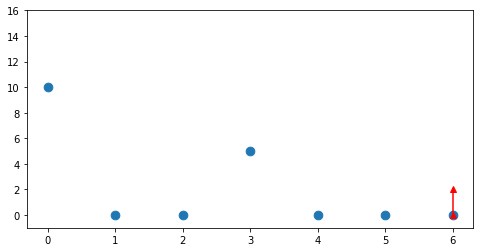

In [11]:
env.render(mode='human')

In [12]:
env.step(LEFT)
env.render()

'position: 5, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 12.000000000000002, normalized total reward: 0.5217391304347827, steps so far: 5, game done: False'

In [13]:
env.step(LEFT)
env.render()

'position: 4, remaining rewards: [10  0  0  5  0  0  0], total reward so far: 11.000000000000004, normalized total reward: 0.4782608695652175, steps so far: 6, game done: False'

In [14]:
env.step(LEFT)
env.render()

'position: 3, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 15.000000000000004, normalized total reward: 0.6521739130434784, steps so far: 7, game done: False'

In [15]:
env.step(LEFT)
env.render()

'position: 2, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 14.000000000000004, normalized total reward: 0.6086956521739132, steps so far: 8, game done: False'

In [16]:
env.step(LEFT)
env.render()

'position: 1, remaining rewards: [10  0  0  0  0  0  0], total reward so far: 13.000000000000004, normalized total reward: 0.565217391304348, steps so far: 9, game done: False'

In [17]:
env.step(LEFT)
env.render()

'position: 0, remaining rewards: [0 0 0 0 0 0 0], total reward so far: 22.000000000000007, normalized total reward: 0.956521739130435, steps so far: 10, game done: True'

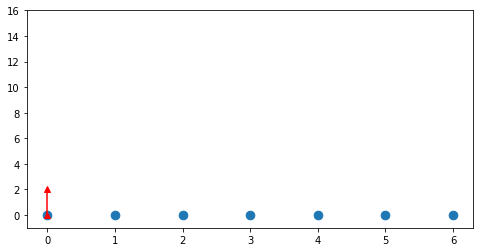

In [18]:
env.render(mode='human')


### Register with OpenAI Gym

In [19]:
from easyagents.env import register_with_gym

env_name = "LineWorld-v0"
register_with_gym(gym_env_name=env_name, entry_point=LineWorldEnv, max_episode_steps=100)

W0917 16:41:33.905703  9328 __init__.py:690] 

  TensorFlow's `tf-nightly` package will soon be updated to TensorFlow 2.0.

  Please upgrade your code to TensorFlow 2.0:
    * https://www.tensorflow.org/beta/guide/migration_guide

  Or install the latest stable TensorFlow 1.X release:
    * `pip install -U "tensorflow==1.*"`

  Otherwise your code may be broken by the change.

  


# Train policy with tfagents PpoAgent

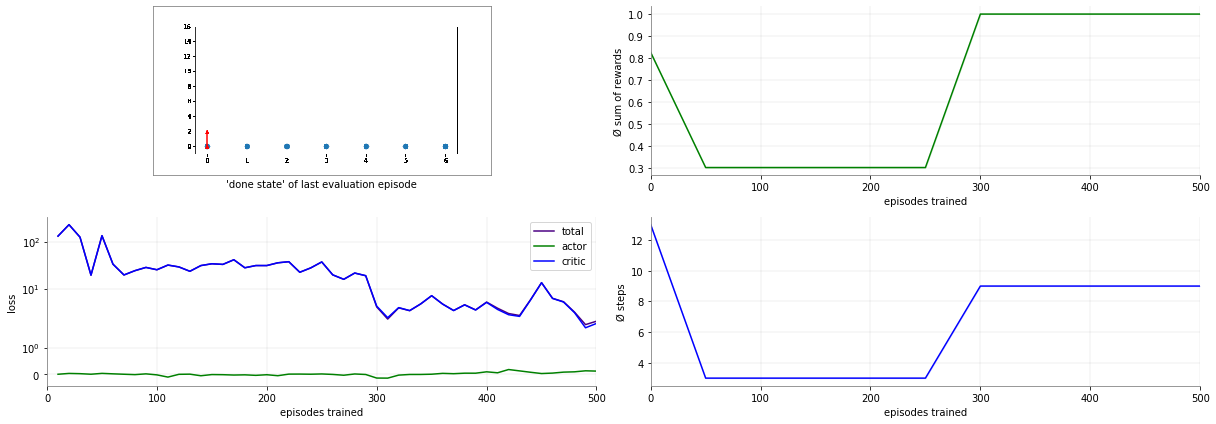

Wall time: 1min 35s


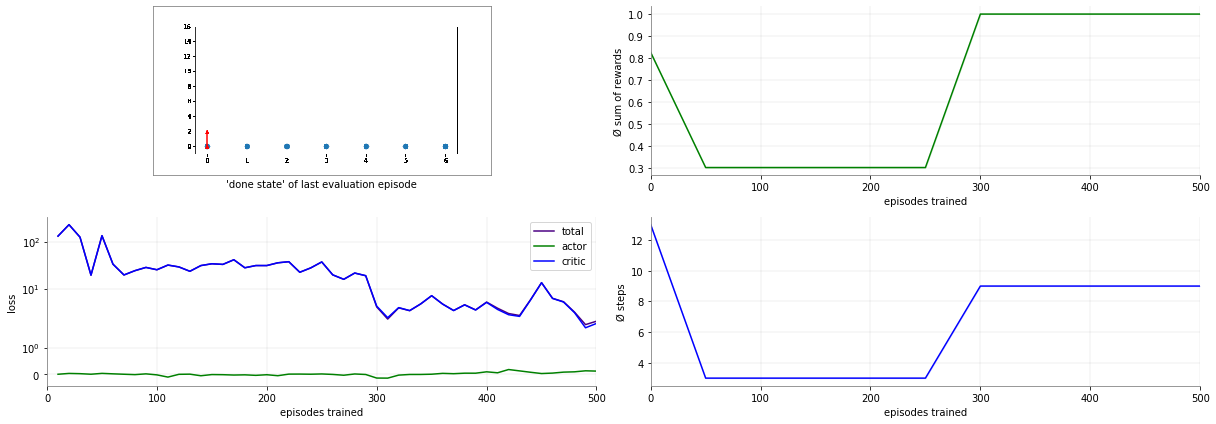

In [22]:
%%time

from easyagents.agents import PpoAgent
from easyagents.callbacks import log, plot

ppoAgent = PpoAgent(gym_env_name = env_name, fc_layers=(500,500,500))

plots = [plot.State(), plot.Rewards(), plot.Loss(), plot.Steps()]
ppoAgent.train(plots, 
               learning_rate=1e-4,
               num_iterations = 50, 
               num_episodes_per_iteration = 10,
               max_steps_per_episode = 50, 
               num_epochs_per_iteration = 5)

# Train policy with tfagents Reinforce

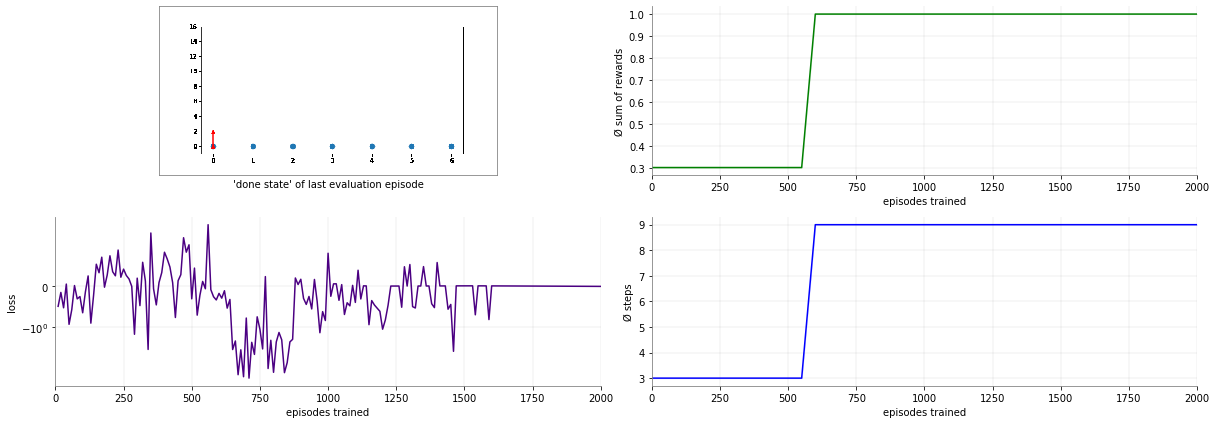

Wall time: 3min 32s


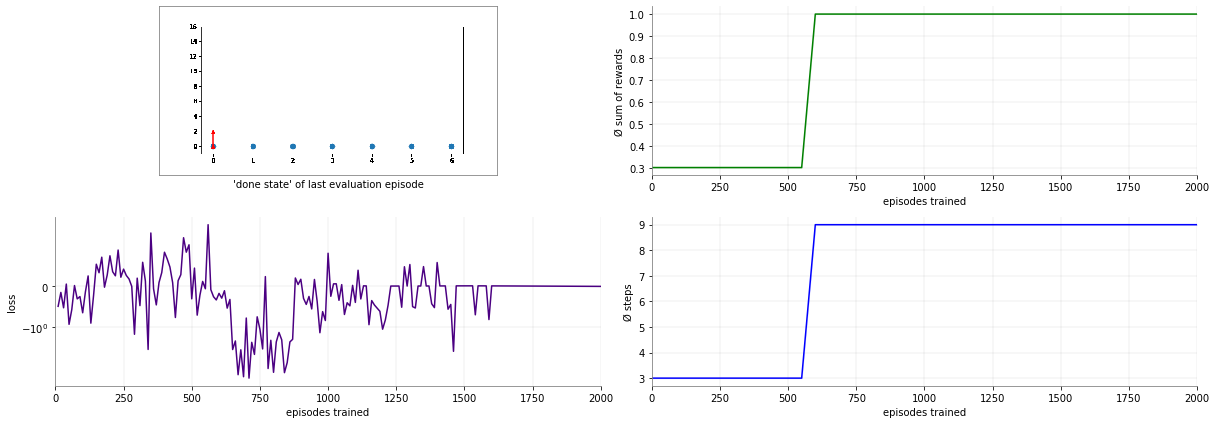

In [21]:
%%time

from easyagents.agents import ReinforceAgent
reinforceAgent = ReinforceAgent(gym_env_name = env_name, fc_layers=(500,500,500))

plots = [plot.State(), plot.Rewards(), plot.Loss(), plot.Steps()]
reinforceAgent.train(
    plots, 
    learning_rate=1e-4,
    num_iterations = 100, 
    num_episodes_per_iteration = 10,
    max_steps_per_episode = 50, 
    num_epochs_per_iteration = 5)